<a href="https://colab.research.google.com/github/devangi2000/Deep-Learning/blob/master/Breast_Cancer_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"devangipurkayastha","key":"eee9f771d1856e6450c4a57eae696e33"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                    title                                              size  lastUpdated          downloadCount  
-----------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
shivan118/healthcare-analytics                         Healthcare Analytics                                2MB  2020-09-13 17:40:05           1123  
datatattle/covid-19-nlp-text-classification            Coronavirus tweets NLP - Text Classification        4MB  2020-09-08 11:40:11            662  
anmolkumar/health-insurance-cross-sell-prediction      Health Insurance Cross Sell Prediction 🏠 🏥          6MB  2020-09-11 18:39:31           1827  
Cornell-University/arxiv                               arXiv Dataset                                     885MB  2020-09-14 16:54:47           2990  
nipunarora8/age-gender-and-ethnicity-face-data-csv     AGE, GENDER AND ETHNICITY (FACE DATA) CSV          

In [ ]:
! kaggle datasets download -d paultimothymooney/breast-histopathology-images

breast-histopathology-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
 ! mkdir train
! unzip breast-histopathology-images -d train

mkdir: cannot create directory ‘train’: File exists
Archive:  breast-histopathology-images.zip
replace train/10253/0/10253_idx5_x1001_y1001_class0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Sequential, Model
from glob import glob
from keras.applications.vgg16 import VGG16, preprocess_input
from numpy.random import seed
seed(101)
#from tensorflow import set_random_seed
#set_random_seed(101)

import pandas as pd
import numpy as np

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
SAMPLE_SIZE = 78786

IMAGE_SIZE = 50


#img_size = [224,224,3]

#train_path = '/train/chest_xray/train'
#valid_path = '/train/chest_xray/valid'
#test_path = '/train/chest_xray/test'

#vgg = VGG16(include_top=False, weights='imagenet', input_shape=img_size)
#for layer in vgg.layers:
 # layer.trainable = False

#num_folders = glob('train/chest_xray/train/*')
#num_folders

In [3]:
os.listdir('train/IDC_regular_ps50_idx5')

['10269',
 '8916',
 '16531',
 '12811',
 '15902',
 '14211',
 '12750',
 '16165',
 '13021',
 '9256',
 '14153',
 '9258',
 '12931',
 '10277',
 '10272',
 '9228',
 '9135',
 '13019',
 '13689',
 '16895',
 '12242',
 '9041',
 '12877',
 '12748',
 '12907',
 '9382',
 '12909',
 '15634',
 '9319',
 '16550',
 '9227',
 '16534',
 '9267',
 '10286',
 '10285',
 '13693',
 '14188',
 '13404',
 '14210',
 '10262',
 '15903',
 '13401',
 '9175',
 '12955',
 '12752',
 '15513',
 '10282',
 '12870',
 '14189',
 '13688',
 '12893',
 '15839',
 '16568',
 '8864',
 '10299',
 '12818',
 '12867',
 '13402',
 '16569',
 '14212',
 '9036',
 '12911',
 '9125',
 '9322',
 '9174',
 '13687',
 '14321',
 '9266',
 '9077',
 '15512',
 '8951',
 '9346',
 '16551',
 '16553',
 '8863',
 '15514',
 '14213',
 '10288',
 '9173',
 '10302',
 '9083',
 '8950',
 '9323',
 '12749',
 '14081',
 '9261',
 '10258',
 '9250',
 '10264',
 '13400',
 '12878',
 '16570',
 '15632',
 '13591',
 '16166',
 '12869',
 '16085',
 '12241',
 '10295',
 '9076',
 '10305',
 '12905',
 '12873'

In [4]:
patients = os.listdir('train/IDC_regular_ps50_idx5')
len(patients)

279

In [5]:
all_images_dir = 'all_images_dir'
os.mkdir(all_images_dir)

FileExistsError: ignored

In [6]:
! ls

 all_images_dir   breast-histopathology-images.zip   kaggle.json   train
 base_dir	 'kaggle (1).json'		     sample_data


In [7]:
# This code copies all images from their seperate folders into the same 
# folder called all_images_dir.

# Create a list with all the patient id numbers.
# Each patient id folder has 2 sub folders --> folder 0 and folder 1

# Example:
    # '10285'
        # '0'
        # '1'

# create a list of all patient id's

patient_list = os.listdir('train/IDC_regular_ps50_idx5')
for patient in patient_list:    
    path_0 = 'train/IDC_regular_ps50_idx5/' + str(patient) + '/0'
    path_1 = 'train/IDC_regular_ps50_idx5/' + str(patient) + '/1'

    # create a list of all files in folder 0
    file_list_0 = os.listdir(path_0)
    # create a list of list all file in folder 1
    file_list_1 = os.listdir(path_1)

    # move the 0 images to all_images_dir
    for fname in file_list_0:

        # source path to image
        src = os.path.join(path_0, fname)
        # destination path to image
        dst = os.path.join(all_images_dir, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

      # move the 1 images to all_images_dir
    for fname in file_list_1:

        # source path to image
        src = os.path.join(path_1, fname)
        # destination path to image
        dst = os.path.join(all_images_dir, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [8]:
# check how many images are in all_images_dir
# should be 277,524

# size: 2.5GB

len(os.listdir('all_images_dir'))

277524

In [11]:
image_list = os.listdir('all_images_dir')

df_data = pd.DataFrame(image_list, columns=['image_id'])

df_data.head()

,image_id
0,10262_idx5_x551_y1401_class0.png
1,10292_idx5_x2201_y901_class0.png
2,9176_idx5_x1651_y1901_class1.png
3,9177_idx5_x2901_y1701_class0.png
4,16533_idx5_x751_y601_class1.png


In [12]:
def extract_patient_id(x):
  a = x.split('_')
  patient_id = a[0]
  return patient_id

In [13]:
def extract_target(x):
  a = x.split('_')
  # the target is part of the string in index 4
  b = a[4]
  # the ytarget i.e. 1 or 2 is the 5th index of the string --> class1
  target = b[5]
  return target

In [14]:
# extract the patient id
# create a new column called 'patient_id' and 'target'
df_data['patient_id'] = df_data['image_id'].apply(extract_patient_id)
df_data['target'] = df_data['image_id'].apply(extract_target)

In [15]:
df_data.head(5)

,image_id,patient_id,target
0,10262_idx5_x551_y1401_class0.png,10262,0
1,10292_idx5_x2201_y901_class0.png,10292,0
2,9176_idx5_x1651_y1901_class1.png,9176,1
3,9177_idx5_x2901_y1701_class0.png,9177,0
4,16533_idx5_x751_y601_class1.png,16533,1


In [16]:
df_data.shape

(277524, 3)

In [17]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name, figure_cols, df, IMAGE_PATH):
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    categories = (df.groupby([col_name])[col_name].nunique().index)
    fig, axis = plt.subplots(nrows=len(categories), ncols=figure_cols, figsize=(4*figure_cols, 4*len(categories)))
    # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
      sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
      for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=cv2.imread(file)
            axis[i, j].imshow(im, resample=True, cmap='gray')
            axis[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()


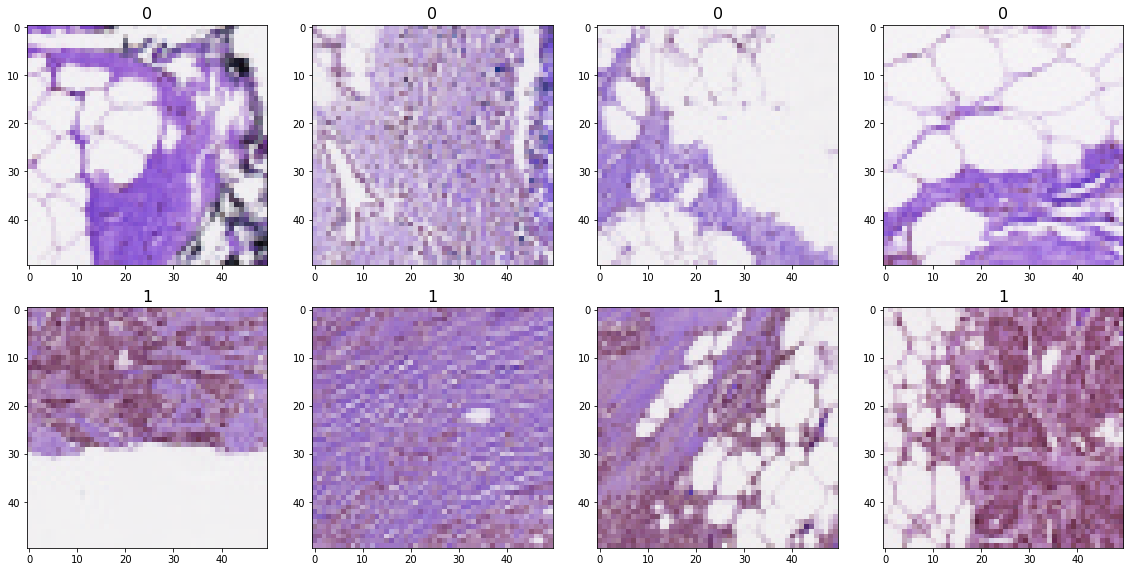

In [18]:
IMAGE_PATH = 'all_images_dir/'

draw_category_images('target',4, df_data, IMAGE_PATH)

In [19]:
# What is the class distribution?

df_data['target'].value_counts()

0    198738
1     78786
Name: target, dtype: int64

In [20]:
# BALANCING THE CLASS DISTRIBUTION
# take a sample of the majority class 0 (total = 198738)

df_0 = df_data[df_data['target']=='0'].sample(SAMPLE_SIZE, random_state=101)
# take a sample of class 1 (total = 78786)
df_1 = df_data[df_data['target']=='1'].sample(SAMPLE_SIZE, random_state=101)

df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

df_data['target'].value_counts()

0    78786
1    78786
Name: target, dtype: int64

In [21]:
# Create the train and val sets
y = df_data['target']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)
print(df_train.shape)
print(df_val.shape)

(141814, 3)
(15758, 3)


In [22]:
df_train['target'].value_counts()

0    70907
1    70907
Name: target, dtype: int64

In [23]:
df_val['target'].value_counts()

1    7879
0    7879
Name: target, dtype: int64

In [24]:
# Create a Directory Structure¶
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_idc
    # b_has_idc

# val_dir
    # a_no_idc
    # b_has_idc

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir

FileExistsError: ignored

In [25]:
a_no_idc = os.path.join(train_dir, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(train_dir, 'b_has_idc')
os.mkdir(b_has_idc)



NameError: ignored

In [ ]:
# create new folders inside val_dir

val_dir = os.path.join(base_dir, 'val_dir')
# os.mkdir(val_dir)
a_no_idc = os.path.join(val_dir, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(val_dir, 'b_has_idc')
os.mkdir(b_has_idc)

In [26]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

['b_has_idc', 'a_no_idc']

In [27]:
# Transfer the images into the folders
df_data.set_index('image_id', inplace=True)
df_data

,patient_id,target
image_id,,
10305_idx5_x2401_y101_class0.png,10305,0
8918_idx5_x851_y1651_class0.png,8918,0
12242_idx5_x1351_y1001_class0.png,12242,0
10285_idx5_x2051_y551_class0.png,10285,0
10301_idx5_x1401_y1751_class0.png,10301,0
...,...,...
9173_idx5_x2051_y1801_class1.png,9173,1
12819_idx5_x1701_y2751_class1.png,12819,1
8974_idx5_x801_y1351_class1.png,8974,1


In [28]:
# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

In [29]:
# Transfer the train images
for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image
    # get the label for a certain image
    target = df_data.loc[image,'target']
    
    # these must match the folder names
    if target == '0':
        label = 'a_no_idc'
    if target == '1':
        label = 'b_has_idc'
    
    # source path to image
    src = os.path.join(all_images_dir, fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # move the image from the source to the destination
    shutil.move(src, dst)
    

NameError: ignored

In [ ]:
for image in val_list:
  # the id in the csv file does not have the .tif extension therefore we add it here
  fname = image
  # getting label for a certain image
  target = df_data.loc[image, 'target']
  # they must match the folder names
  if target =='0':
    label = 'a_no_idc'
  if target == '1':
    label = 'b_has_idc'

  # source path to image
  src = os.path.join(all_images_dir, fname)
  # destination path to image
  dest = os.path.join(val_dir, label, fname)

  shutil.move(src, dest)

In [30]:
print(len(os.listdir('base_dir/train_dir/a_no_idc')))
print(len(os.listdir('base_dir/train_dir/b_has_idc')))

78016
77975


In [31]:

print(len(os.listdir('base_dir/val_dir/a_no_idc')))
print(len(os.listdir('base_dir/val_dir/b_has_idc')))


7879
7879


In [32]:
# Set Up the Generators
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)

train_batch_size = 10
val_batch_size = 10

train_steps = np.ceil(num_train_samples/train_batch_size)
val_steps = np.ceil(num_val_samples/val_batch_size)

In [33]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_datagen = datagen.flow_from_directory(
    train_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = train_batch_size,
    class_mode = 'categorical'
)


val_datagen = datagen.flow_from_directory(
    valid_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = val_batch_size,
    class_mode = 'categorical'
)

Found 155991 images belonging to 2 classes.
Found 15758 images belonging to 2 classes.


In [34]:
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 15758 images belonging to 2 classes.


In [35]:
# Create the Model Architecture

kernel_size = (3,3)
pool_size = (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation='relu', input_shape= (IMAGE_SIZE, IMAGE_SIZE,3)))
model.add(Conv2D(first_filters, kernel_size, activation='relu'))
model.add(Conv2D(first_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_dense))
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 64)        3

In [36]:
# Train the Model

model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, 
                             mode='max')

In [38]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, verbose=1,
                              mode='max', min_lr=0.00001)
callback_list = [checkpoint, reduce_lr]

In [39]:
history = model.fit_generator(train_datagen, steps_per_epoch=train_steps,
                              validation_data=val_datagen,
                              validation_steps=val_steps,
                              epochs=60,
                              verbose=1,
                              callbacks=callback_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/60
14182/14182 [==============================] - 113s 8ms/step - loss: 0.4614 - accuracy: 0.7931 - val_loss: 0.4265 - val_accuracy: 0.8106
Epoch 2/60
14182/14182 [==============================] - 100s 7ms/step - loss: 0.3967 - accuracy: 0.8305 - val_loss: 0.3822 - val_accuracy: 0.8393
Epoch 3/60
14182/14182 [==============================] - 100s 7ms/step - loss: 0.3752 - accuracy: 0.8422 - val_loss: 0.3628 - val_accuracy: 0.8485
Epoch 4/60
14182/14182 [==============================] - 101s 7ms/step - loss: 0.3623 - accuracy: 0.8483 - val_loss: 0.3510 - val_accuracy: 0.8516
Epoch 5/60
14182/14182 [==============================] - 101s 7ms/step - loss: 0.3526 - accuracy: 0.8528 - val_loss: 0.3457 - val_accuracy: 0.8554
Epoch 6/60
14182/14182 [==============================] - 101s 7ms/step - loss: 0.3456 - accuracy: 0.8563 - val_loss: 0.3333 - val_accuracy: 0.8594
Epoch 7/60
14182/14182 [============

In [40]:
# Evaluate the model using the val set
model.metrics_names

['loss', 'accuracy']

In [43]:
import tensorflow as tf
from keras.models import load_model

model.save('model.h5')

In [47]:
#from keras.models import load_weights

model = load_model('model.h5')

val_loss, val_acc = model.evaluate_generator(test_gen,
                         steps=len(df_val))

print('Validation Loss : ', val_loss)
print('Validation Accuracy : ', val_acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Validation Loss :  0.24349583685398102
Validation Accuracy :  0.9029064774513245


<Figure size 432x288 with 0 Axes>

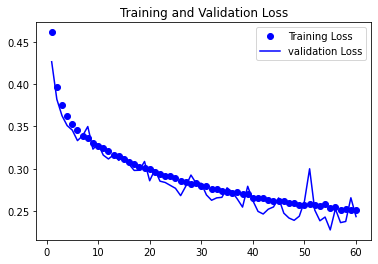

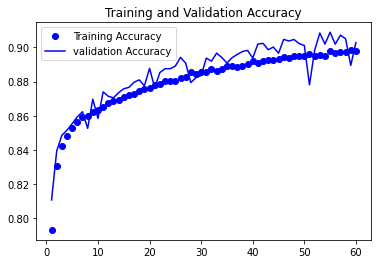

<Figure size 432x288 with 0 Axes>

In [48]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = "validation Loss")
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = "validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

In [49]:
# Make a prediction on the val set
# We need these predictions to calculate the AUC score,
# print the Confusion Matrix and calculate the F1 score.

# make a prediction

predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
15758/15758 [==============================] - 30s 2ms/step


In [50]:
predictions.shape

(15758, 2)

In [51]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'a_no_idc': 0, 'b_has_idc': 1}

In [52]:
# Put the predictions into a dataframe.
# The columns need to be ordered to match the output of the previous cell
df_preds = pd.DataFrame(predictions, columns=['no_idc', 'has_idc'])

df_preds.head()


,no_idc,has_idc
0,0.325674,0.674326
1,0.956576,0.043424
2,0.741112,0.258888
3,0.778076,0.221924
4,0.823927,0.176073


In [53]:
predictions

array([[0.32567438, 0.67432564],
       [0.95657575, 0.04342426],
       [0.7411122 , 0.2588878 ],
       ...,
       [0.00183485, 0.9981652 ],
       [0.36559427, 0.6344057 ],
       [0.26142976, 0.7385702 ]], dtype=float32)

In [54]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_idc']

In [55]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.9662246552723345

In [56]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [58]:
test_labels.shape

(15758,)

In [59]:
test_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [60]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [61]:
# Print the label associated with each class
test_gen.class_indices

{'a_no_idc': 0, 'b_has_idc': 1}

Confusion matrix, without normalization
[[6869 1010]
 [ 520 7359]]


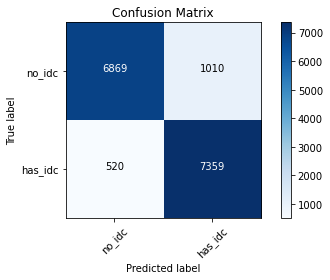

In [62]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['no_idc', 'has_idc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [63]:
from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

      no_idc       0.93      0.87      0.90      7879
     has_idc       0.88      0.93      0.91      7879

    accuracy                           0.90     15758
   macro avg       0.90      0.90      0.90     15758
weighted avg       0.90      0.90      0.90     15758



In [64]:
!pip install tensorflowjs

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 92kB 7.2MB/s 
     |████████████████████████████████| 137.3MB 101kB/s 
     |████████████████████████████████| 256kB 55.0MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32852 sha256=2947d061327fb23b77b83cb740e3d1d94266bf00c601e31deb39c9d05f4df521
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation: tensorflow-hub 0.9.0
    Uninstalling tensorflow-hub-0.9.0:
      Successfully uninstalled tensorflow-hub-0.9.0


In [65]:
# Use the command line conversion tool to convert the model

!tensorflowjs_converter --input_format keras model.h5 tfjs_model_1/model

In [ ]:
# Delete all_images_dir and base_dir directory to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

#shutil.rmtree('all_images_dir')
#shutil.rmtree('base_dir')